<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/basics/neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌸 ニューラルネットワークの基礎：データを分類する

このノートブックでは、**「分類（Classification）」** というタスクを通じて、機械学習とニューラルネットワークの仕組みを体験します。

## 🧠 この教材のゴール
1.  **分類問題の理解**: データの特徴から「種類（クラス）」を当てる仕組みを学びます。
2.  **ニューラルネットワーク**: 人間の脳神経を模したモデル（入力層・隠れ層・出力層）の構造を可視化します。
3.  **学習のプロセス**: 失敗（損失）から学び、徐々に賢くなっていく過程をグラフで確認します。

## ⚙️ 必要なライブラリ
* `numpy`: 数値計算
* `scikit-learn`: 機械学習全般（データの用意、モデル構築、評価）
* `matplotlib` / `seaborn`: データの可視化

In [15]:
#@title ライブラリのインポート

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.utils import shuffle
import seaborn as sns
from tqdm import tqdm
random_state = 42  # 乱数のシード

import warnings
from sklearn.exceptions import ConvergenceWarning

# ConvergenceWarningを無視するように設定
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 【追加】確率の合計が厳密に1でない場合の警告 (UserWarning) を無視
warnings.filterwarnings("ignore", message="The y_pred values do not sum to one")

## 📚 データセットの選択

機械学習の練習によく使われる、3つの有名なデータセットから1つを選んで分析します。

| データセット名 | 目的 | 特徴量 ($x$) の例 | クラス ($y$) |
| :--- | :--- | :--- | :--- |
| **Iris** (アヤメ) | 3種類の品種を分類 | 花弁の長さ、ガクの幅など (4次元) | Setosa, Versicolor, Virginica |
| **Wine** (ワイン) | 3種類のワインを分類 | アルコール度数、色味など (13次元) | Class 0, 1, 2 |
| **Breast Cancer** | 良性・悪性腫瘍の判定 | 患部の半径、テクスチャなど (30次元) | Malignant(悪性), Benign(良性) |

以下のフォームでデータセットを選択し、実行してください。

In [ ]:
#@title データセットの読み込み
dataset_name = "Iris" # @param ["Iris","Wine","Breast Cancer"]

from sklearn.datasets import load_iris, load_wine, load_breast_cancer
import pandas as pd
from sklearn.utils import shuffle
import sys
from IPython.display import display

# データセットをロードする関数
def load_dataset(dataset_name):
    if dataset_name == "Iris":
        dataset = load_iris()
        feature_names = dataset.feature_names
        # feature_names = ["ガクの長さ", "ガクの幅", "花弁の長さ", "花弁の幅"]
        target_names = dataset.target_names
    elif dataset_name == "Wine":
        dataset = load_wine()
        feature_names = dataset.feature_names
        target_names = dataset.target_names
    elif dataset_name == "Breast Cancer":
        dataset = load_breast_cancer()
        feature_names = dataset.feature_names
        # target_names = dataset.target_names
        target_names = ["Malignant (bad)", "Benign (good)"]
    else:
        print("誤った番号です")
        return None, None, None, None, None, None

    X = dataset.data
    y = dataset.target
    return dataset.data, dataset.target, pd.DataFrame(X, columns=feature_names), pd.Series(y, name="CLASS"), dataset_name, target_names, feature_names

# データセットのロード
X, y, feature_df, y_df, dataset_name, target_names, feature_names = load_dataset(dataset_name)

if X is not None:
    # クラス名を追加
    y_class_names = y_df.map(lambda x: target_names[x]).rename("CLASS_NAME")

    # 特徴量とクラス、クラス名を結合したDataFrameを作成
    df_combined = pd.concat([y_df, y_class_names, feature_df], axis=1)

    # データをシャッフル
    df_shuffled = shuffle(df_combined, random_state=42).reset_index(drop=True)

    # 表示
    display(df_shuffled.head())

### 🧐 課題1. データの構造を理解する

表示された表（DataFrame）を見て、データの構造を確認しましょう。

1.  **サンプルの数え方**: ひとつのサンプル（1本の花、1本のワインボトル、1人の患者）は、表の「行（横）」ですか？「列（縦）」ですか？
2.  **データの意味**:
    * **正解（クラス）**: 予測したい答えはどの列ですか？
    * **特徴量（次元数）**: 予測の手がかりとなる数値データは、1サンプルあたりいくつありますか？
3.  **モデルの役割**:
    > 今回の機械学習モデルでは、各サンプルがもつ **「＿＿＿＿＿＿＿（特徴量/クラス）」** に基づいて、そのデータが各クラスに属する **「確率」** を計算し、その値が最大となるクラスに分類します。

> **あなたの回答:**
> （ここをダブルクリックして記述してください）

## 📊 データの可視化

数字の羅列だけではデータの傾向がつかめません。
データセットの特徴量のうち2つを選んで散布図（Scatter Plot）を描き、**「種類ごとにデータがどのように分布しているか」** を視覚的に確認します。

* **うまく分類できそうなデータ**: 同じ色の点が固まっていて、他の色と離れている。
* **難しいデータ**: 違う色の点が混ざり合っている。

In [ ]:
#@title データの可視化

# 任意のクラス数に対応するカラーパレットを生成する関数
def generate_color_palette(n_colors):
    return plt.cm.get_cmap('tab10', n_colors)

# 特徴量のうち、2つを選んで散布図を描く関数
def plot_2d_projection(X, y, feature_indices, feature_names, target_names, title=""):
    plt.figure(figsize=(8, 6))
    palette = generate_color_palette(len(np.unique(y)))
    for target in np.unique(y):
        subset = X[y == target]
        plt.scatter(subset[:, feature_indices[0]], subset[:, feature_indices[1]], label=f"Class {target}: {target_names[target]}", color=palette(target))
    plt.xlabel(f"Feature {feature_indices[0]}: {feature_names[0]}")
    plt.ylabel(f"Feature {feature_indices[1]}: {feature_names[1]}")
    plt.title(title)
    plt.legend()
    plt.show()

# 特徴量の組み合わせを選んでプロット
if X is not None:
    plot_2d_projection(X, y, feature_indices=[0, 1], feature_names=feature_names, target_names=target_names, title=f"{dataset_name} Data - Features 0 and 1")

## 🏫 データの分割：練習・模試・本番

AIのモデル開発においては、全てのデータを学習に使ってしまうと、答えを丸暗記してしまい、未知の問題（未来のデータ）に対応できなくなります。これを防ぐため、データを3つに分割します。

1.  **教師データ (Training Data)**: 📖 **教科書・問題集**
    * モデルが学習するために使います。正解を見ながら法則性を学びます。
2.  **検証データ (Validation Data)**: 📝 **模擬試験**
    * 学習の途中で、「今の実力でどれくらい解けるか」を確認するために使います。この結果を見て、パラメータ（設定）を調整します。
3.  **テストデータ (Test Data)**: 🎓 **本番の試験**
    * 最後の最後まで取っておきます。最終的なモデルの性能を評価するために1回だけ使います。

In [ ]:
#@title データの分割

# One-hotエンコーディング
encoder = OneHotEncoder()
y_onehot = encoder.fit_transform(y.reshape(-1, 1)).toarray()

# データを分割 (70% training, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 分割結果の確認

# DataFrameの作成
def create_df(X, y, feature_names, target_names):
    y_classes = [target_names[i] for i in y.argmax(axis=1)]
    y_class_series = pd.Series(y_classes, name="CLASS_NAME")
    return pd.concat([pd.DataFrame(X, columns=feature_names), y_class_series], axis=1)

df_train = create_df(X_train, y_train, feature_names, target_names)
df_val = create_df(X_val, y_val, feature_names, target_names)
df_test = create_df(X_test, y_test, feature_names, target_names)

# 表示
print("\n[教師データ]")
print("サイズ:", X_train.shape)
display(df_train.head())

print("\n[検証データ]")
print("サイズ:", X_val.shape)
display(df_val.head())

print("\n[テストデータ]")
print("サイズ:", X_test.shape)
display(df_test.head())

### 🧐 課題2. データの使い分け

すべてのデータを3つに分割しました。それぞれの役割を再確認しましょう。

* **教師データ**: （記述してください）
* **検証データ**: （記述してください）
* **テストデータ**: （記述してください）

## 🧠 ニューラルネットワークの構築

いよいよモデルを作成します。ここでは `MLPClassifier` (Multi-Layer Perceptron) を使用します。

### ネットワークの構造
人間の脳にある神経細胞（ニューロン）のつながりを模倣した構造です。

1.  **入力層 (Input Layer)**: 特徴量を受け取る入口。次元数と同じ数のノードがあります。
2.  **隠れ層 (Hidden Layer)**: 情報を複雑に処理する中間層。ここの層やノードを増やすと「思考力」が上がりますが、計算が大変になります。
3.  **出力層 (Output Layer)**: ネットワークの出力。クラスの数だけノードがあり、それぞれのクラスにあたる確率を出力します。

### 次元の選択
まずは視覚的に理解しやすくするため、特徴量を**2つだけ**（2次元）使って学習させます。
※ 本格的に精度を上げたい場合は、チェックを外してください

In [ ]:
#@title 2次元の特徴量のみを使用するか否か
use_two_features = True # @param {"type":"boolean"}

# 2次元の特徴量を選択する関数
def select_two_features(X, feature_indices):
    return X[:, feature_indices]

# 特徴量の次元数を選択するかどうか
feature_indices = [0, 1]

if use_two_features:
    X_train_transformed = select_two_features(X_train, feature_indices)
    X_val_transformed = select_two_features(X_val, feature_indices)
    X_test_transformed = select_two_features(X_test, feature_indices)
    clms = feature_df.columns[0:2]
else:
    X_train_transformed = X_train
    X_val_transformed = X_val
    X_test_transformed = X_test
    clms = feature_df.columns

## 📉 損失関数 (Loss Function) の役割

**損失関数**とは、モデルの予測が「どれだけ間違っているか」を採点するルールです。
学習のゴールは、この点数（Loss）を**0に近づけること**です。ここでは、代表的な3つの損失関数を比較します。

#### **1. マンハッタン距離 (Manhattan Distance / L1損失)** 🏙️

* **考え方**: 予測と正解の「差の絶対値」を合計します。各クラスのズレをそのまま足し合わせる、シンプルで直感的な方法です。
* **特徴**: 外れ値（極端に大きい間違い）の影響を受けにくいという利点があります。
* **計算例**:
    * **理想の出力**: `[0, 1, 0]`
    * **モデルの出力**: `[0.1, 0.7, 0.2]`
    * **損失**: `|0 - 0.1| + |1 - 0.7| + |0 - 0.2| = 0.1 + 0.3 + 0.2 = 0.6`

#### **2. ユークリッド距離 (Euclidean Distance / L2損失)** 📏

* **考え方**: 予測と正解の「差の2乗」を合計します。幾何学的な"直線距離"の2乗を計算するイメージです。
* **特徴**: 差を2乗するため、**大きな間違いに対してより厳しいペナルティ**を与えます。これにより、モデルは大きく外すことを避けるように学習が進みます。
* **計算例**:
    * **理想の出力**: `[0, 1, 0]`
    * **モデルの出力**: `[0.1, 0.7, 0.2]`
    * **損失**: `(0 - 0.1)² + (1 - 0.7)² + (0 - 0.2)² = 0.01 + 0.09 + 0.04 = 0.14`

#### **3. クロスエントロピー (Cross-Entropy / Log Loss)** 🔥

* **考え方**: 2つの「確率分布」がどれだけ似ていないかを測る指標です。分類問題の出力は確率なので、最も理にかなった方法です。
* **特徴**: **「自信満々に、大間違いしたとき」に爆発的に大きなペナルティ**を与えます。モデルは「正解のクラスの確率」を100%に近づけることだけに集中するようになります。分類問題では最も標準的に使われます。
* **計算例**: One-hot表現の場合、計算は「正解のクラス」の確率だけを見て、他は無視します。
    * **理想の出力**: `[0, 1, 0]` （正解は真ん中）
    * **モデルの出力**: `[0.1, 0.7, 0.2]`
    * **損失**: 正解である真ん中の確率 **0.7** だけを使います。式は $-\log(\text{正解の確率})$ です。
        $$-\log(0.7) \approx 0.36$$
    * **比較**: もし正解の確率が **0.1** しかなかったら？
        $$-\log(0.1) \approx 2.30$$
        このように、正解の確率が低い（自信がない/間違っている）と、ペナルティ（損失）が急激に跳ね上がります。

In [ ]:
#@title 損失関数の選択

import numpy as np
from sklearn.metrics import log_loss
import torch
import torch.nn.functional as F

#@title 損失関数を選択して実行してください { run: "auto" }
loss_function_name = "クロスエントロピー" #@param ["マンハッタン距離", "ユークリッド距離", "クロスエントロピー"]

# --------------------------------------------------
# 1. 各損失関数の定義 (修正版)
# --------------------------------------------------

def manhattan_loss(y_true_one_hot, y_pred_proba):
    """
    マンハッタン距離 (L1損失) を計算。
    y_true_one_hot は既にone-hot表現であることを想定。
    """
    # y_true_one_hot は既に正しい形なので、そのまま計算に使う
    loss = np.sum(np.abs(y_pred_proba - y_true_one_hot)) / len(y_true_one_hot)
    return loss

def euclidean_loss(y_true_one_hot, y_pred_proba):
    """
    ユークリッド距離の2乗 (MSE) を計算。
    y_true_one_hot は既にone-hot表現であることを想定。
    """
    # y_true_one_hot は既に正しい形なので、そのまま計算に使う
    loss = np.sum((y_pred_proba - y_true_one_hot)**2) / len(y_true_one_hot)
    return loss

def cross_entropy_loss(y_true_one_hot, y_pred_proba):
    """
    クロスエントロピー損失 (log_loss) を計算。
    scikit-learnのlog_lossはクラス番号を要求するため、one-hotを元に戻す。
    """
    # one-hot表現 (例: [0, 1, 0]) からクラス番号 (例: 1) に変換
    y_true_labels = np.argmax(y_true_one_hot, axis=1)
    return log_loss(y_true_labels, y_pred_proba)

# --------------------------------------------------
# 2. 「関数ポインタ」の役割を果たす辞書を作成
# --------------------------------------------------
loss_functions = {
    "マンハッタン距離": manhattan_loss,
    "ユークリッド距離": euclidean_loss,
    "クロスエントロピー": cross_entropy_loss,
}

# プルダウンメニューで選択された名前から、使用する関数を取得
selected_loss_func = loss_functions[loss_function_name]

## ⚙️ モデルの学習設定

ニューラルネットワークの形状（アーキテクチャ）を定義します。
`hidden_layer_sizes` を変更すると、隠れ層の数やノード数を調整できます（例: `[10, 5]` なら2層構造）。

In [ ]:
#@title モデルの形状

hidden_layer_sizes = [5, ]  # 隠れ層のノード数。複数の層にしたい場合は [3,4] や [3,5,4] など
batch_size = 32            # バッチサイズ（ミニバッチサイズ）。１回の学習に用いられるサンプルの数

import matplotlib.pyplot as plt
import networkx as nx

def draw_mlp_network(input_nodes, hidden_layers, output_nodes):
    """
    MLPのネットワークを描画する関数

    Parameters:
    - input_nodes: 入力層のノード数
    - hidden_layers: 隠れ層のノード数のリスト
    - output_nodes: 出力層のノード数
    """
    G = nx.DiGraph()

    # ノードの追加
    layers = [input_nodes] + hidden_layers + [output_nodes]
    layer_pos = []
    max_nodes = max(layers)

    for i, layer in enumerate(layers):
        # 中央揃えにするためのオフセット計算
        offset = (max_nodes - layer) / 2
        current_layer = []
        for j in range(layer):
            if i == 0:
                node_id = f'in_{j}'
            elif i == len(layers) - 1:
                node_id = f'out_{j}'
            else:
                node_id = f'hidden{i-1}_{j}'
            G.add_node(node_id, pos=(i, max_nodes - (j + offset)))
            current_layer.append(node_id)
        layer_pos.append(current_layer)

    # エッジの追加
    for i in range(len(layers) - 1):
        for node_start in layer_pos[i]:
            for node_end in layer_pos[i + 1]:
                G.add_edge(node_start, node_end)

    # ノードの位置を取得
    pos = nx.get_node_attributes(G, 'pos')

    # グラフの描画
    plt.figure(figsize=(8, 6))  # 横幅を800pxに設定するための調整
    nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue", font_size=8)
    plt.title('MLP Network Structure')
    plt.show()


# モデルの構築
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1, warm_start=True, random_state=random_state, batch_size=batch_size)

# 構造の描画
draw_mlp_network(input_nodes=X_train_transformed.shape[1], hidden_layers=hidden_layer_sizes, output_nodes=len(target_names))

## 🏃‍♂️ 学習の実行

定義したモデルに教師データを与え、学習を開始します。

* **Epoch (エポック)**: 教科書（学習データ）を「一通り全部読み終わる」こと。
* **Loss (損失)**: 下がるほど良い。
* **Accuracy (正解率)**: 上がるほど良い。

グラフがどのように変化するか観察してください。

Epoch 1000/1000 - Train accuracy: 0.6857, Train loss: 0.4700, Val accuracy: 0.8182, Val loss: 0.2858


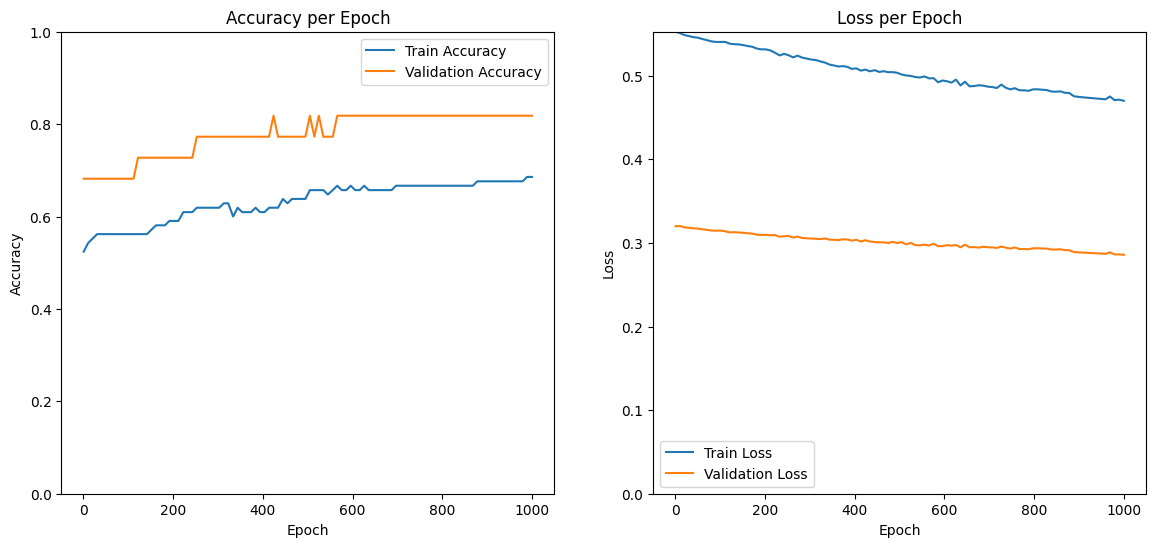

In [16]:
#@title 学習の実行

max_epochs = 1000           # 最大エポック数

# トレーニングループ
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# tqdmを使って進行状況バーを表示
with tqdm(total=max_epochs, leave=False) as pbar:
    for epoch in range(max_epochs):
        mlp.fit(X_train_transformed, y_train)

        # 教師データでの予測と評価
        y_train_pred = mlp.predict(X_train_transformed)
        y_train_pred_proba = mlp.predict_proba(X_train_transformed)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_loss = selected_loss_func(y_train, y_train_pred_proba)

        # 検証データでの予測と評価
        y_val_pred = mlp.predict(X_val_transformed)
        y_val_pred_proba = mlp.predict_proba(X_val_transformed)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_loss = selected_loss_func(y_val, y_val_pred_proba)

        # 記録
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # tqdmの説明文を更新
        pbar.set_description(f"Epoch {epoch + 1}/{max_epochs} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Train acc: {train_accuracy:.4f}, Val acc: {val_accuracy:.4f}")
        pbar.update(1)

# 最後のエポックの結果を表示
print(f"Epoch {max_epochs}/{max_epochs} - Train accuracy: {train_accuracy:.4f}, Train loss: {train_loss:.4f}, Val accuracy: {val_accuracy:.4f}, Val loss: {val_loss:.4f}")

# プロット用の間引き
def reduce_points(data, num_points):
    if len(data) > num_points:
        indices = np.linspace(0, len(data) - 1, num_points, dtype=int)
        return [data[i] for i in indices]
    return data

# グラフで学習の様子を表示

num_points = 100
epochs = range(1, max_epochs + 1)
epochs_reduced = reduce_points(list(epochs), num_points)
train_accuracies_reduced = reduce_points(train_accuracies, num_points)
val_accuracies_reduced = reduce_points(val_accuracies, num_points)
train_losses_reduced = reduce_points(train_losses, num_points)
val_losses_reduced = reduce_points(val_losses, num_points)

# プロット
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_reduced, train_accuracies_reduced, label='Train Accuracy')
plt.plot(epochs_reduced, val_accuracies_reduced, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title('Accuracy per Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_reduced, train_losses_reduced, label='Train Loss')
plt.plot(epochs_reduced, val_losses_reduced, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_losses_reduced), max(val_losses_reduced)))
plt.legend()
plt.title('Loss per Epoch')

plt.show()

### 🧐 課題3. 学習の仕組み

グラフと用語の理解を確認します。空欄を埋めてみてください。

1.  学習では **「＿＿＿＿＿＿（損失 / 正解率）」** の値を小さくすることを目指します。
2.  このとき、ネットワークの予測（確率）と、正解の **「One-hot」** 表現を比較します。この比較計算に用いるのが **「＿＿＿＿＿関数」** です。
3.  グラフを見ると、学習が進むにつれて：
    * 左のグラフ（Accuracy）は **「＿＿＿＿（上がる / 下がる）」**
    * 右のグラフ（Loss）は **「＿＿＿＿（上がる / 下がる）」**
4.  用語の定義：
    * **1 エポック**: データを一通り学習に使い切ること。
    * **バッチ**: データを小分けにする単位。今回の `batch_size` は **「＿＿＿＿＿」** です。
    * **バックプロパゲーション (誤差逆伝播法)**: 損失が小さくなるように、ネットワークの重みを修正する処理のこと。

## 🧪 学習の様子を確認

学習に使った「教師データ」と、学習には使っていない「検証データ」での成績を数値で確認します。
もし教師データの成績だけが極端に良くて、検証データの成績が悪い場合、それは **過学習 (Overfitting)** の可能性があります。

In [ ]:
#@title  教師データや検証データで試す

# 教師データでの予測
y_train_pred = mlp.predict(X_train_transformed)
y_train_pred_proba = mlp.predict_proba(X_train_transformed)

# 教師データでの評価
train_accuracy = accuracy_score(y_train, y_train_pred)
train_loss = selected_loss_func(y_train, y_train_pred_proba)

print(f"教師データでの精度: {train_accuracy:.3f}")
print(f"教師データでの損失: {train_loss:.3f}")

# 検証データでの予測
y_val_pred = mlp.predict(X_val_transformed)
y_val_pred_proba = mlp.predict_proba(X_val_transformed)

# 検証データでの評価
val_accuracy = accuracy_score(y_val, y_val_pred)
val_loss = selected_loss_func(y_val, y_val_pred_proba)

print(f"検証データでの精度: {val_accuracy:.3f}")
print(f"検証データでの損失: {val_loss:.3f}")

## 🔍 推論プロセスの追跡

「学習済みモデル」の中身はブラックボックスになりがちです。
ここでは検証データのうち1つのサンプルに注目し、データがどのように処理されて結果が出るのかを追跡します。

- **ネットワークへの入力（特徴量）**

    検証データから特定のサンプルを選び、その特徴量ベクトルを表示します。これは、ネットワーク（モデル）に入力されるデータで、各特徴量が数値として表現されています。

- **ネットワークの出力（確率）**

    選択した入力に対して、モデルが各クラスに属する確率を計算します。この確率は、入力がそれぞれのクラスに分類される可能性を示しており、各クラスに対して1つの確率値が出力されます。

- **推定されたクラス番号の one-hot 表現**

    モデルが予測したクラスのone-hot表現を表示します。one-hot表現とは、正解クラスを1、それ以外のクラスを0とするベクトル形式のことです。例えば4クラスの場合、[0, 0, 1, 0] はクラス 2 を示します（注：クラス番号は 0 から始まります）。

- **クラス推定の表示（整数表現）**

    one-hot表現のベクトルを整数に変換し、予測されたクラスを数値として示します。

In [ ]:
#@title 1つのサンプルを入力

# 特徴量ベクトルを入力し、各クラスの確率を出力
sample_index = 1  # 任意のサンプルインデックス
sample_input = X_val_transformed[sample_index].reshape(1, -1)  # 1サンプルの入力データ
print("ネットワークへの入力（特徴量）　　 ：", sample_input)

# 確率の出力
class_probabilities = mlp.predict_proba(sample_input)
print("ネットワークの出力（確率）　　 　　：", class_probabilities)

# クラス推定
predicted_class = mlp.predict(sample_input)
print("推定されたクラス番号の one-hot 表現：", predicted_class)
print("推定されたクラス番号　　　　　　　 ：", np.argmax(predicted_class))

# クラス推定
predicted_class = mlp.predict(sample_input)
print("正解の one-hot 表現　　　　　　　　：", y_train[sample_index])
print("正解　　　　　　　　　　　　　　　 ：", np.argmax(y_train[sample_index]))

### 🧐 課題4. 予測結果の解読

上のコードの実行結果（出力）を見ながら、以下のレポートを完成させてください。

> あるサンプルの特徴量（数値）をネットワークに入力したところ、各クラスに対する確率が出力されました。
> その中で、**「＿＿＿＿ 番目（0から数えて）」** のクラスの確率が最も高くなりました。
> したがって、AIが推定したクラスは **「＿＿＿＿」** となりました。

## 🏁 最終テスト (Test Data)

最後に、これまで一度も使っていない「テストデータ」を使って、モデルの真の実力を測ります。
これが実際の運用環境での性能に近い数値となります。

In [ ]:
#@title 全テストデータの結果を表示
all_test_samples = []

for i in range(len(X_test_transformed)):
    test_sample = X_test_transformed[i].reshape(1, -1)
    probabilities = mlp.predict_proba(test_sample)[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = target_names[predicted_class_index]
    true_class_index = np.argmax(y_test[i])
    true_class_name = target_names[true_class_index]

    test_sample_df = pd.DataFrame(test_sample, columns=clms)
    test_sample_df["正解"] = f"クラス{true_class_index}-{true_class_name}"
    test_sample_df["推論"] = f"クラス{predicted_class_index}-{predicted_class_name}"

    # 各クラスの確率を追加
    for class_index, prob in enumerate(probabilities):
        test_sample_df[f"クラス{class_index}の確率"] = round(prob, 3)

    # カラムの順番を調整
    probability_columns = [f"クラス{class_index}の確率" for class_index in range(len(probabilities))]
    test_sample_df = test_sample_df[
        ["正解", "推論"] + probability_columns + clms.tolist()
    ]

    all_test_samples.append(test_sample_df)

all_test_samples_df = pd.concat(all_test_samples, ignore_index=True)

print("全テストデータの結果:")
display(all_test_samples_df)

### テストデータの総合スコア

さらに、テストデータにおいて精度（正解率）および損失を計算してみましょう。

In [ ]:
#@title 総合スコアの計算
# テストデータでの予測
y_test_pred = mlp.predict(X_test_transformed)
y_test_pred_proba = mlp.predict_proba(X_test_transformed)

# テストデータでの評価
test_accuracy = accuracy_score(y_test, y_test_pred)
test_loss = selected_loss_func(y_test, y_test_pred_proba)

print(f"テストデータでの精度: {test_accuracy:.4f}")
print(f"テストデータでの損失: {test_loss:.4f}")

### 🧐 課題5. 最終結果の確認

「全テストデータの結果」の表の**最初の1行**を読み取ってください。

> 最初のサンプルについて、モデルは各クラスの確率を `[0.xxx, 0.xxx, ...]` と計算しました。
> 最大の確率を持つクラスは **「＿＿＿」** であったため、推論結果は **「＿＿＿」** となりました。
> これは正解と **（一致していた / 異なっていた）**。

## 🗺️ 決定境界 (Decision Boundary) の可視化

2次元の特徴量を用いた場合、モデルが「どこでクラスを区切ったか」を地図のように描画できます。
これを **決定境界** と呼びます。

* 色が変わる境界線が、AIの判断の分かれ目です。
* 背景の色は、モデルが「その領域ならこのクラスだ」と予測する範囲を表しています。

In [ ]:
#@title グリッドサーチによる領域プロット
def plot_decision_boundary(clf, X, y, feature_indices, feature_names, title=""):
    # グリッドを生成
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # グリッド全体で予測を実行
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    # プロットの描画
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    palette = plt.cm.get_cmap('tab10', len(np.unique(np.argmax(y, axis=1))))
    for target in np.unique(np.argmax(y, axis=1)):
        subset = X[np.argmax(y, axis=1) == target]
        plt.scatter(subset[:, feature_indices[0]], subset[:, feature_indices[1]], label=f"Class {target}: {target_names[target]}", color=palette(target))
    plt.xlabel(f"Feature {feature_indices[0]}: {feature_names[0]}")
    plt.ylabel(f"Feature {feature_indices[1]}: {feature_names[1]}")
    plt.title(title)
    plt.legend()
    plt.show()

# 特徴量の組み合わせを選んでプロット
if use_two_features == True:
  plot_decision_boundary(mlp, X_test_transformed, y_test, feature_indices, feature_names, title=f"Decision Boundary for {dataset_name} Dataset")
else:
  print("3次元以上の特徴量を使用しているため実行されません")

### 🧐 課題6. 境界線の意味と過学習

1.  **決定境界**: クラスを分ける境界線のこと。これを適切な位置に引けるようになることが「学習」の本質です。
2.  **過学習 (Overfitting)**:
    * もし境界線が、学習データの点ひとつひとつを囲むように**細かくクネクネと曲がりくねって**いたら要注意です。
    * それは「過去問（教師データ）」を丸暗記しすぎて、未知の問題（テストデータ）に対応できない状態を意味します。
    * これを防ぐために、**検証データ**を使って学習を早めに止めたり、モデルをシンプルに保つ工夫をします。

## 📝 課題7. 総合課題

ある機械学習の初学者が、今日学んだ「ニューラルネットワークによる分類」についてレポートを書きましたが、いくつか重大な勘違いがあるようです。
文章中の **太字** になっている部分（5箇所）には誤りがあります。なぜそれが間違っているのかを考え、正しい説明に修正してください。

---

### ❌ 間違いだらけのレポート

「今回、私はニューラルネットワークを使った分類モデルを作りました。
まず、このネットワークは、データの **正解クラス（品種やラベルなど）** を入力として受け取り、計算結果としてそのデータの **特徴量（数値データ）** を出力する仕組みになっています。

学習の目的は、データがきれいに分類できるように、クラスとクラスを分ける **損失関数** という線を、適切な位置に引くことです。
学習中、モデルは予測と正解を比較して点数をつけますが、この点数（損失）ができるだけ **大きく** なるように、ネットワークの重みを更新し続けます。

なお、計算しやすくするために、正解ラベル（正解クラス）は `[0, 0, 1]` のような **決定境界** 表現に変換してから使用しました。
学習が終わったモデルを使えば、新しいサンプルのクラスを推定できます。」

---



### ✅ あなたの修正案

1.  **入力と出力**:
    * 誤: 入力が「正解クラス」、出力が「特徴量」
    * 正: （ここに正しい入出力を書いてください）
2.  **境界線の名前**:
    * 誤: クラスを分ける線を「損失関数」という
    * 正: クラスを分ける線は「＿＿＿＿」という
3.  **学習の目標**:
    * 誤: 損失ができるだけ「大きく」なるようにする
    * 正: 損失ができるだけ「＿＿＿＿」なるようにする
4.  **ベクトルの名前**:
    * 誤: `[0, 0, 1]` のような形式を「決定境界」表現という
    * 正: `[0, 0, 1]` のような形式を「＿＿＿＿」表現という

---

# 🚀 次のステップ：画像認識 (CNN) へ

今回の実験では、特徴量が多くても 30個（数値）程度でした。
しかし、画像認識の世界では、小さな画像（32x32ピクセル）でも $32 \times 32 \times 3 \text{(RGB)} = 3072$ 個もの数値（特徴量）になります。

これをそのまま入力するのではなく、**「畳み込み (Convolution)」** という処理を使って、画像の重要な特徴（エッジや模様など）を自動で取り出してから学習する手法が **CNN (畳み込みニューラルネットワーク)** です。

### 🔗 関連する演習
* [NumPy の演習](https://github.com/shizoda/education/blob/main/machine_learning/numpy.ipynb): 多次元配列の操作
* [画像表現の演習](https://github.com/shizoda/education/blob/main/image/colors.ipynb): コンピュータは画像をどう見ているか
* [CNN を用いた画像分類の演習](https://github.com/shizoda/education/blob/main/machine_learning/cnn/cifar10_pytorch.ipynb): より高度な画像認識へ